In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image
from tqdm import tqdm 

In [3]:
# Görüntü Boyutu
IMAGE_SIZE = (256, 256) 
# Mini-batch boyutu
BATCH_SIZE = 32 
# Sınıf Sayısı: Güneşli, Yağmurlu, Bulutlu, Gün Doğumu
NUM_CLASSES = 4 
# Hiper-parametreler
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

Kullanılan Cihaz: cpu


In [4]:
DATA_DIR = r"C:\Users\Muhammet\Desktop\DerinÖğrenme_Projesi\archive\Multi-class Weather Dataset"



# 2. Veri Dönüşümleri (Transformations)

print("2. Veri Artırımı ve Normalizasyon Ayarları Yapılıyor...")

common_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    common_transforms
])

val_test_transforms = transforms.Compose([
    common_transforms
])

2. Veri Artırımı ve Normalizasyon Ayarları Yapılıyor...


In [5]:
# -----------------------------------------------------------------------------
# 3. Veri Kümelerini Yükleme
# -----------------------------------------------------------------------------
print(f"3. Veri Kümeleri '{DATA_DIR}' yolundan yükleniyor...")

try:
    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)
    class_names = full_dataset.classes
    print(f"Bulunan Sınıflar: {class_names}")
except FileNotFoundError:
    print(f"HATA: '{DATA_DIR}' yolu bulunamadı.")
    raise

total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Eğitim: {len(train_dataset)}, Doğrulama: {len(val_dataset)}, Test: {len(test_dataset)}")


3. Veri Kümeleri 'C:\Users\Muhammet\Desktop\DerinÖğrenme_Projesi\archive\Multi-class Weather Dataset' yolundan yükleniyor...
Bulunan Sınıflar: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Eğitim: 787, Doğrulama: 168, Test: 170


In [6]:
# -----------------------------------------------------------------------------
# 4. Wide CNN Model Mimarisi
# -----------------------------------------------------------------------------
print("\n4. Wide CNN Model Mimarisi Tanımlanıyor...")

class WideCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(WideCNN, self).__init__()
        
        # Blok 1: 64 Filtre
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25) 
        )
        # Blok 2: 128 Filtre
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        # Blok 3: 256 Filtre (Geniş)
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.flatten_size = 32 * 32 * 256 
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = WideCNN(num_classes=NUM_CLASSES).to(DEVICE)


4. Wide CNN Model Mimarisi Tanımlanıyor...


In [8]:
# 5. Modelin Derlenmesi
# -----------------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -----------------------------------------------------------------------------
# 6. Eğitim Döngüsü 

print("\n6. Eğitim Başlıyor...")

train_losses, val_losses = [], []

train_accs, val_accs = [], [] 

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
      
        if (i+1) % 5 == 0:
             print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Step [{i+1}/{len(train_loader)}] - Loss: {loss.item():.4f}")
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation
    model.eval()
    val_running_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss = val_running_loss / len(val_dataset)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"--- SONUÇ: Epoch {epoch+1} Bitti | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f} ---\n")

print("Eğitim Tamamlandı.")



6. Eğitim Başlıyor...
Epoch [1/20] - Step [5/25] - Loss: 3.7289
Epoch [1/20] - Step [10/25] - Loss: 0.9227
Epoch [1/20] - Step [15/25] - Loss: 0.8394
Epoch [1/20] - Step [20/25] - Loss: 0.6331
Epoch [1/20] - Step [25/25] - Loss: 0.9675
--- SONUÇ: Epoch 1 Bitti | Train Acc: 0.6137 | Val Acc: 0.6369 ---

Epoch [2/20] - Step [5/25] - Loss: 0.3100
Epoch [2/20] - Step [10/25] - Loss: 0.5401
Epoch [2/20] - Step [15/25] - Loss: 0.6740
Epoch [2/20] - Step [20/25] - Loss: 0.6869
Epoch [2/20] - Step [25/25] - Loss: 0.1912
--- SONUÇ: Epoch 2 Bitti | Train Acc: 0.7891 | Val Acc: 0.8333 ---

Epoch [3/20] - Step [5/25] - Loss: 0.3791
Epoch [3/20] - Step [10/25] - Loss: 0.2897
Epoch [3/20] - Step [15/25] - Loss: 0.3826
Epoch [3/20] - Step [20/25] - Loss: 0.3398
Epoch [3/20] - Step [25/25] - Loss: 1.0812
--- SONUÇ: Epoch 3 Bitti | Train Acc: 0.8018 | Val Acc: 0.8036 ---

Epoch [4/20] - Step [5/25] - Loss: 0.3920
Epoch [4/20] - Step [10/25] - Loss: 0.1908
Epoch [4/20] - Step [15/25] - Loss: 0.2823
Epo

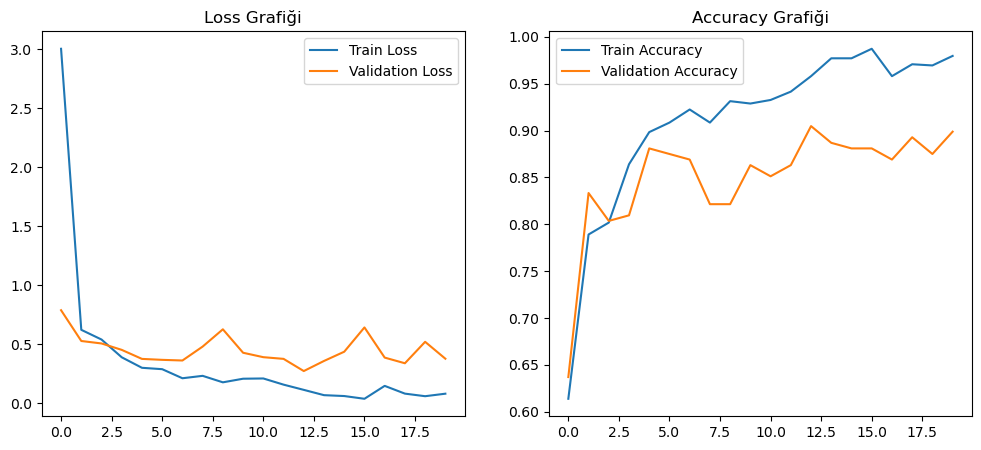


8. Test Seti Değerlendirmesi Yapılıyor...

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      Cloudy       0.81      0.91      0.86        43
        Rain       0.92      0.80      0.86        30
       Shine       0.84      0.86      0.85        37
     Sunrise       1.00      0.97      0.98        60

    accuracy                           0.90       170
   macro avg       0.89      0.88      0.89       170
weighted avg       0.90      0.90      0.90       170



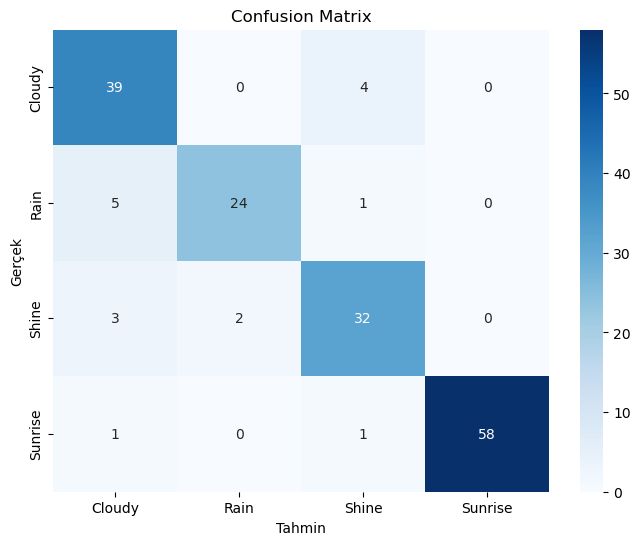

In [14]:
# -----------------------------------------------------------------------------
# 7. Sonuçların Görselleştirilmesi
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Grafiği')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# 8. Test Seti Değerlendirmesi
# -----------------------------------------------------------------------------
print("\n8. Test Seti Değerlendirmesi Yapılıyor...")

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()



9. Model Kaydediliyor ve Örnek Tahmin Yapılıyor...
✅ Model ağırlıkları 'wide_cnn_weather_model.pth' olarak kaydedildi.

--- Rastgele Test Örneği ---


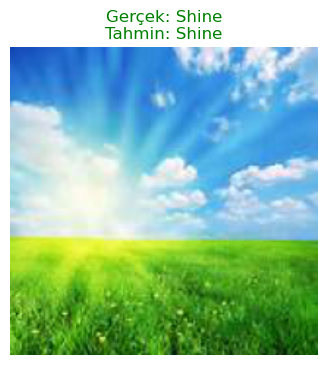

Örnek Tahmin -> Gerçek: Shine, Model Tahmini: Shine

🎉 TEBRİKLER! Tüm süreç başarıyla tamamlandı.


In [15]:
# 9. Modelin Kaydedilmesi ve Örnek Tahmin (Final Adım)
# -----------------------------------------------------------------------------
print("\n9. Model Kaydediliyor ve Örnek Tahmin Yapılıyor...")

# Modeli Kaydetme
model_save_path = 'wide_cnn_weather_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model ağırlıkları '{model_save_path}' olarak kaydedildi.")

# Test Setinden Rastgele Bir Görüntü Alıp Tahmin Etme Fonksiyonu
def predict_random_image(model, dataset, classes):
    model.eval()
    idx = random.randint(0, len(dataset)-1)
    image, label = dataset[idx] # image: Tensor, label: int
    
    # Model tahmini için boyutu (1, 3, 256, 256) yapmalıyız (Batch boyutu ekle)
    image_tensor = image.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = classes[predicted_idx.item()]
        true_class = classes[label]
    
   
    img_np = image.permute(1, 2, 0).numpy()
    
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.title(f"Gerçek: {true_class}\nTahmin: {predicted_class}", 
              color=("green" if true_class == predicted_class else "red"))
    plt.axis('off')
    plt.show()
    print(f"Örnek Tahmin -> Gerçek: {true_class}, Model Tahmini: {predicted_class}")

# Tahmin Fonksiyonunu Çalıştır
print("\n--- Rastgele Test Örneği ---")
predict_random_image(model, test_dataset, class_names)

print("\n🎉 TEBRİKLER! Tüm süreç başarıyla tamamlandı.")